# Deep Q- learning Agent- Stock Trading

In this notebook, we will train an agent to trade 2 and 4 specific stocks at a time in order to maximize the profit. We will be using Deep Q-Learning.

## Getting the data from the Repo

In [1]:
!git clone https://github.com/Costopoulos/EV-Charging-Reinforcement-Learning.git

Cloning into 'EV-Charging-Reinforcement-Learning'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), 824.00 KiB | 3.63 MiB/s, done.


In [2]:
%cd EV-Charging-Reinforcement-Learning/

/kaggle/working/EV-Charging-Reinforcement-Learning


## Imports

In [3]:
import keras
import random
import math
import gym
import sys
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from datetime import datetime, timedelta
from collections import deque

### Important Definitions
<ul> 
    <li><strong>stock1_name</strong>:   This is first stock name, is Apple - aapl.us</li>
    <li><strong>stock2_name</strong>:   This is second stock name, is Amazon - amzn.us</li>
    <li><strong>episode_count</strong>: This is number of episodes the agent will train on. In our case it's 50</li>
    <li><strong>start_balance</strong>: This is the initial budget, which is $10,000</li>
    <li><strong>training</strong>:      How many days each episode will last. Defaults at 1500</li>
    <li><strong>test</strong>:          Number of days that the test will run on. Defaults at 500 </li>
 </ul>

In [4]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 5 # buy_1, sell_1, do Nothing, buy2, sell2
        self.memory = deque(maxlen=2000) # deque is basically a list that provides O(1) pop & append methods
        self.inventory1 = []
        self.inventory2 = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95 # gamma is the discount factor. It quantifies how much importance we give for future rewards.
        self.epsilon = 1.0 # Exploration and Exploitation — Epsilon (ε) for ε - greedy
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model("models/" + model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon: # ε - greedy; act randomly if random returns sth < epsilon
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        minibatch = random.sample(self.memory, batch_size) # mini_batch
        
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
              
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=2)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

In [5]:
class State:
    def __init__(self, data1, data2, Bal_stock1, Bal_stock2, open_cash, timestep):
        self.Stock1Price=data1[timestep] # stock 1 open price
        self.Stock2Price=data2[timestep] # stock 2 open price
        self.Stock1Blnc=Bal_stock1 # stock 1 balance
        self.Stock2Blnc=Bal_stock2 # stock 2 balance
        self.open_cash=open_cash # cash balance
        self.fiveday_stock1=self.five_day_window(data1, timestep)
        self.fiveday_stock2=self.five_day_window(data2, timestep)
        self.portfolio_value=self.portfolio_value()

    def portfolio_value(self):
        pvalue=0

        v1=self.Stock1Price * float(self.Stock1Blnc)
        v2=self.Stock2Price * float(self.Stock2Blnc)
        v3=float(self.open_cash)
        return (v1+v2+v3)
    
    def five_day_window(self,data, timestep):
        step = timestep
        if step < 5:
            return data[0]
        
        stock_5days = np.mean(data[step-5:step])

        return stock_5days
    
    def reset(self):
        self.Stock1Price=151.25 # stock 1 open price Google
        self.Stock2Price=21.845 # stock 2 open price Walmart
        self.Stock1Blnc=34 # stock 1 balance Google
        self.Stock2Blnc=221 # stock 2 balance Walmart
        self.open_cash=10000 # cash balance
        self.fiveday_stock1=151.25
        self.fiveday_stock2=21.845
        self.portfolio_value=10000
        
    def getState(self):
        res=[]
        res.append(self.Stock1Price) # stock 1 open price
        res.append(self.Stock2Price) # stock 2 open price
        res.append(self.Stock1Blnc) # stock 1 balance
        res.append(self.Stock2Blnc) # stock 2 balance
        res.append(self.open_cash) # cash balance
        res.append(self.fiveday_stock1)
        res.append(self.fiveday_stock2)        
        res.append(self.portfolio_value)

        res1=np.array([res])
        return res1

In [6]:
stock_name1, stock_name2, episode_count, start_balance, training, test = 'aapl.us', 'amzn.us', 12, 10000, 1500, 500

pd_data1 = pd.read_csv('data/aapl.us.txt', sep=",", header=0)
pd_data2 = pd.read_csv('data/amzn.us.txt', sep=",", header=0)

## Data Pre-processing

In this section we will do the following:
1. Look at the data of Apple and Amazon stock for checking anamolies (missing data etc.). Also convert date into right format
2. Make sure that both the stock data is for the same time period and same days in this time period. Remove data if necessary
3. Look at descriptive statistics of data- mean, median, number of records
4. Visualize the data to see how stock price changes with time
    

#### View First Stock's data

In [7]:
pd_data1.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [8]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,8364.000000,8364.000000,8364.000000,8364.000000,8.364000e+03,8364.0
mean,22.284350,22.495867,22.054244,22.281018,1.066416e+08,0.0
std,37.763402,38.057733,37.447432,37.764469,9.935187e+07,0.0
min,0.233050,0.235640,0.230510,0.230510,0.000000e+00,0.0
25%,1.137100,1.164200,1.112800,1.137100,4.384365e+07,0.0
50%,1.632800,1.663400,1.600600,1.628250,7.481383e+07,0.0
75%,23.739000,23.930500,23.335750,23.694500,1.320534e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


#### View Second Stock's data


In [9]:
pd_data2.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [10]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5153.000000,5153.000000,5153.000000,5153.000000,5.153000e+03,5153.0
mean,181.747357,183.880652,179.466684,181.769343,7.837325e+06,0.0
std,239.611052,241.226109,237.638139,239.548391,7.594745e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.130000,35.000000,35.550000,3.779449e+06,0.0
50%,70.900000,72.750000,69.020000,70.700000,5.902992e+06,0.0
75%,242.850000,245.770000,240.670000,243.880000,8.888949e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


#### Drop Data that is not in both stock data- some days' data is missing in stock1 and some in stock2

In [11]:
# Convert Date to DateTime
def dateToDatetime(df1, df2):
    df1['Date'] = pd.to_datetime(df1['Date'], format='%Y/%m/%d')
    df2['Date'] = pd.to_datetime(df2['Date'], format='%Y/%m/%d')
    return df1, df2

def firstFilteringOut(df1, df2):
    if (df1['Date'][0] > df2['Date'][0]): 
        df1 = df1[df1.Date>=df2['Date'][0]]
        df1 = df1.reset_index(drop=True)
    else:
        df2 = df2[df2.Date>=df1['Date'][0]]
        df2 = df2.reset_index(drop=True)
    
    return df1, df2

# Drop columns for which data is missing in stock1 or stock2
def dropDataNotInBothStocks(df1, df2):
    df1, df2 = firstFilteringOut(df1, df2)
    list1 = df1['Date']
    list2 = df2['Date']
    diff_df1 = list(set(list1) - set(list2))
    diff_df2 = list(set(list2) - set(list1))
    
    for k in range(len(diff_df1)):
        df1_datetime_str = diff_df1[k].strftime('%Y-%m-%d 00:00:00')
        df1_datetime = datetime.strptime(df1_datetime_str, "%Y-%m-%d 00:00:00")
        for i, j in enumerate(list1):
            if j == df1_datetime:
                df1 = df1.drop([i])
    
    for k in range(len(diff_df2)):
        df2_datetime_str = diff_df2[k].strftime('%Y-%m-%d 00:00:00')
        df2_datetime = datetime.strptime(df2_datetime_str, "%Y-%m-%d 00:00:00")
        for i, j in enumerate(list2):
            if j == df2_datetime:
                df2 = df2.drop([i])
    
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    
    return df1, df2

def preprocess2Stocks(df1, df2):
    df1, df2 = dateToDatetime(df1, df2)
    df1, df2 = dropDataNotInBothStocks(df1, df2)
    return df1, df2

In [12]:
pd_data1, pd_data2 = preprocess2Stocks(pd_data1, pd_data2)

Now the data is clean, both stock1 and stock2 have 5151 records

In [13]:
pd_data1['Date'][0]

Timestamp('1997-05-16 00:00:00')

In [14]:
pd_data2['Date'][0]

Timestamp('1997-05-16 00:00:00')

In [15]:
pd_data1.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,35.484689,35.816124,35.123519,35.479585,1.367661e+08,0.0
std,43.150378,43.473086,42.805762,43.153299,1.119530e+08,0.0
min,0.412350,0.423880,0.408530,0.413660,0.000000e+00,0.0
25%,1.518700,1.552100,1.488200,1.521300,6.327315e+07,0.0
50%,12.362000,12.710000,12.060000,12.403000,1.075093e+08,0.0
75%,64.097000,64.834000,63.631500,64.308500,1.764941e+08,0.0
max,175.110000,175.610000,174.270000,175.610000,2.069770e+09,0.0


In [16]:
pd_data2.describe()

,Open,High,Low,Close,Volume,OpenInt
count,5151.000000,5151.000000,5151.000000,5151.000000,5.151000e+03,5151.0
mean,181.812687,183.946772,179.531361,181.834821,7.835138e+06,0.0
std,239.634626,241.249596,237.661600,239.571842,7.594587e+06,0.0
min,1.410000,1.450000,1.310000,1.400000,0.000000e+00,0.0
25%,35.500000,36.230000,35.010000,35.580000,3.777334e+06,0.0
50%,70.940000,72.810000,69.020000,70.730000,5.901100e+06,0.0
75%,243.035000,246.240000,241.015000,243.900000,8.888874e+06,0.0
max,1126.100000,1135.540000,1124.060000,1132.880000,1.043288e+08,0.0


### Data Visualization

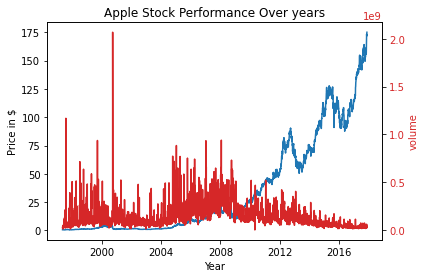

In [17]:
# Stock1 Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x1 = np.array(pd_data1['Date'])
y1 = pd_data1['Open']
y12= pd_data1['Volume']

plt.title("Apple Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")
plt.plot(x1,y1)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x1, y12, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

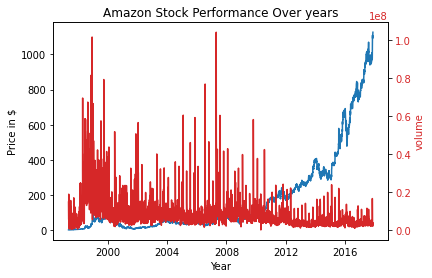

In [18]:
# Stock2 Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

x2 = np.array(pd_data2['Date'])
y2 = pd_data2['Open']
y22= pd_data2['Volume']


plt.title("Amazon Stock Performance Over years")
plt.xlabel("Year")
plt.ylabel("Price in $")

plt.plot(x2,y2)


ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('volume', color=color)  # we already handled the x-label with ax1
ax2.plot(x2, y22, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

## Split Training and Test data

Next step is to divide data into training and test set. This has to be done in a chronological order. So, data is divided into:
- training set from days 0 to days 'training'
- test set: from days 'training' to day 'training+ test'

In [19]:
def train_test_split(df, train_size, test_size):
    df_train = df[0:train_size]
    df_test = df[train_size:train_size+test_size]
    
    return df_train, df_test

In [20]:
# Split
pd_data1_train, pd_data1_test = train_test_split(pd_data1, training, test)
pd_data2_train, pd_data2_test = train_test_split(pd_data2, training, test)

Make the pd_data'INDEX'_test variables act like lists (have numerical indexes)

In [21]:
pd_data1_test = pd_data1_test.reset_index(drop=True)
pd_data2_test = pd_data2_test.reset_index(drop=True)

## Initialize state and set benchmarking model

In [22]:
total_Prof=[]
done=False


batch_size = 64

#Benchmark Model
#In this model, we would divide 


#Initialize state and set benchmarking model


#print(df_data1)
total_Prof=[]
done=False

Act_datasize = training
batch_size = 64

#Benchmark Model

data1_train=pd_data1_train['Open']
data2_train=pd_data2_train['Open']

data1_date=pd_data1_train['Date']

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_train[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_train[0]))
Act_Bench_Open_cash=start_balance/2


### Program to calculate benchmark profit


#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):
    #print("closing prices : " + str(data1_train[j-1]) )
    Price_closing_Stock1=data1_train[j-1]
    Price_closing_Stock2=data2_train[j-1]

    date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
    #print(date_stock1)

    stocks1Value= Act_stocks1 * Price_closing_Stock1
    stocks2Value= Act_stocks2 * Price_closing_Stock2
    remaining_stock1=remaining_stock1-Act_stocks1
    remaining_stock2=remaining_stock2-Act_stocks2
    #print("J is:"+ str(j))



    Stock1_Port_value=remaining_stock1*Price_closing_Stock1
    Stock2_Port_value=remaining_stock2*Price_closing_Stock2
    Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash

    Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
    Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        



#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Training_Benchmark_Portfolio_Value= Total_Portfolio_value


print("Benchmark_Profit is  " + str(Training_Benchmark_Portfolio_Value) +"with Apple Stocks:  " + str(remaining_stock1) + 
      " and Amazon stocks:  "+ str(remaining_stock2) )


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

Benchmark_Profit is  52655.37275with Apple Stocks:  6.0 and Amazon stocks:  9.0


## Training

In [23]:
#Training run

import csv


for e in range(episode_count + 1):
    print("..........")
    print("Episode " + str(e) + "/" + str(episode_count))
    
    Bal_stock1=int(np.floor((start_balance/4)/data1_train[0]))
    Bal_stock2=int(np.floor((start_balance/4)/data2_train[0]))
    open_cash=start_balance/2
    
    datasize=training
    done=False
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent = Agent(8)
    agent.inventory1 =[]
    agent.inventory2 =[]
    for i in range(Bal_stock1):
        agent.inventory1.append(data1_train[0])
    for i in range(Bal_stock2):
        agent.inventory2.append(data2_train[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    #timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(datasize):
        #print("..........")
        #print(pd_data1_train.iloc[t,0])
        state_class_obj= State(data1_train, data2_train, Bal_stock1, Bal_stock2, open_cash,t)
        state_array_obj=state_class_obj.getState()
        action = agent.act(state_array_obj)
         
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        #print("change_percent_stock1:  "+str(change_percent_stock1))
        #print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                '''
                print("Buy stock 1 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent.inventory1.append(data1_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                #needs to be reviewed
                
                if(state_class_obj.open_cash<500):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:  
                    reward=-change_percent_stock1*100
                

               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                reward=-200000
                done = True
                #end episode
            else:
                #print("In sell stock 1")
                bought_price1=agent.inventory1.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                if(state_class_obj.Stock1Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock1)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock1*100 #State[0] is the price of stock 1. Here we are buying 1 stock
                
                #total_profit += data1_train[t] - bought_price1
            #print("reward for sell stock1 " + str(reward))
                
        


        
        if action == 2:             # Do nothing action    
                if (abs(change_percent_stock1)<=2) and (abs(change_percent_stock2)<=2):
                    reward=10000
                elif (state_class_obj.open_cash<0.1*start_balance):
                    reward=1000000
                elif (abs(change_percent_stock1)<=2) or (abs(change_percent_stock2)<=2):
                    reward=1000
                else:
                    reward=-100000
                
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=open_cash
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
                reward=-200000
                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_train[t])
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash-state_class_obj.Stock2Price
                
                if(state_class_obj.open_cash<5000):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=-change_percent_stock2*100
 
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    reward=-200000
                    done = True
                #end episode
            else:
                #print("In sell stock 2")
                bought_price2=agent.inventory2.pop(0)
                Bal_stock1_t1= len(agent.inventory1)
                Bal_stock2_t1=len(agent.inventory2)
                open_cash_t1=state_class_obj.open_cash+state_class_obj.Stock2Price
    
              
                if(state_class_obj.Stock2Blnc<10):
                    reward=-100000
                elif (abs(change_percent_stock2)<=2):
                    reward=-10000
                else:
                    reward=change_percent_stock2*100 
                
                
                total_profit += state_class_obj.Stock2Price - bought_price2

               # print("reward for selling stock2: " + str(reward))
            
        
        
        #print("reward:  "+str(reward))
        #if done!= False:done = True if t == datasize
        if t == datasize-1:
            #print("t==datasize")
            done=True
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            next_state_class_obj=State(data1_train, data2_train, Bal_stock1_t1, Bal_stock2_t1, open_cash_t1,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        agent.memory.append((state_array_obj, action, reward, next_state_array_obj, done))
        #print("Action is "+str(action)+" reward is" + str(reward))
         
        Bal_stock1=Bal_stock1_t1
        Bal_stock2= Bal_stock2_t1
        open_cash=open_cash_t1
        
        
      #  print("total_profit on day basis " + str(total_profit) +"on day"+str(t) + "stock 1 number: " + 
        #      str(len(agent.inventory1))+"/"+str(next_state_class_obj.Stock1Blnc)+" stock2 number:"+
         #         str(len(agent.inventory2)) +"/"+str(next_state_class_obj.Stock2Blnc)+
          #        "open cash: "+str(next_state_class_obj.open_cash))
        
       # print("doneAction" + str(done))
       # print("--------------------------------") 
       
        
        
        if done==True:
            #print("--------------------------------")
           # print("Total Profit: " + formatPrice(total_profit))
           # print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(datasize))
           # print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
             #     "  stock 1 number: " + str(len(agent.inventory1))
            #      +"  stock 2 number: "+str(len(agent.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            total_Prof.append(total_profit)
            total_stock1bal.append(len(agent.inventory1))
            total_stock2bal.append(len(agent.inventory2))
            total_open_cash.append(state_class_obj.open_cash)
            total_port_value.append(state_class_obj.portfolio_value)
            total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break
           
          

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    if e % 10 == 0:
        agent.model.save("models/model_ep" + str(e))
        

        
#print("Total Apple stocks in episodes"+ str(total_stock1bal))
#print("Total Amazon stocks in episodes"+ str(total_stock2bal))
#print("Total Open cash in episodes"+ str(total_open_cash))
#print("Total Portfolio value in episodes"+ str(total_port_value))
#print("Total Days in episodes"+ str(total_days_played))
#print("Benchmark_Profit is  " + str(int(Benchmark_Portfolio_Value)) +"   with Apple Stocks: " + str(Bench_Stock1_Bal) + 
    #  "   and Amazon stocks: "+ str(Bench_Stock2_Bal) )

..........
Episode 0/12


2022-03-11 17:19:12.851423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 17:19:12.937180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 17:19:12.937875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 17:19:12.939048: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

--------------------------------


2022-03-11 17:19:57.095378: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


..........
Episode 1/12
--------------------------------
..........
Episode 2/12
--------------------------------
..........
Episode 3/12
--------------------------------
..........
Episode 4/12
--------------------------------
..........
Episode 5/12
--------------------------------
..........
Episode 6/12
--------------------------------
..........
Episode 7/12
--------------------------------
..........
Episode 8/12
--------------------------------
..........
Episode 9/12
--------------------------------
..........
Episode 10/12
--------------------------------
..........
Episode 11/12
--------------------------------
..........
Episode 12/12
--------------------------------


In [24]:
print("Total Apple stocks in episodes"+ str(total_stock1bal))
print("Total Amazon stocks in episodes"+ str(total_stock2bal))
print("Total Open cash in episodes"+ str(total_open_cash))
print("Total Portfolio value in episodes"+ str(total_port_value))
print("Total Days in episodes"+ str(total_days_played))

print("Benchmark_Profit is  " + str(int(Training_Benchmark_Portfolio_Value)) +"   with remaining Apple Stocks: " + str(remaining_stock1) + 
      "   and remaining Amazon stocks: "+ str(remaining_stock2) )

Total Apple stocks in episodes[4448, 3458, 4465, 5704, 5707, 4467, 4456, 4474, 5689, 4494, 4339, 3241, 4461]
Total Amazon stocks in episodes[45, 1277, 36, 1262, 1271, 37, 1274, 1485, 1258, 1395, 1119, 1275, 600]
Total Open cash in episodes[44144.28191999996, 6505.683780000001, 44126.12804999998, 3274.4146000000023, 3040.9219100000064, 43924.71483, 4544.214860000003, 26.776660000006316, 3110.6396500000005, 16.10593000001262, 8763.772489999992, 6869.238280000007, 35463.12716999996]
Total Portfolio value in episodes[51028.56191999996, 52993.55878, 50732.633049999975, 51969.2096, 52037.59191000001, 50566.76983, 52134.054860000004, 108416.63945999999, 51654.79965, 102004.58233000002, 51077.13248999999, 53029.348280000006, 60755.77216999997]
Total Days in episodes[1499, 1499, 1499, 1499, 1499, 1499, 1499, 457, 1499, 460, 1499, 1499, 1499]
Benchmark_Profit is  52655   with remaining Apple Stocks: 6.0   and remaining Amazon stocks: 9.0


## Benchmark model for Actual Test Run

In [25]:
#Initialize state and set benchmarking model

import datetime

#print(df_data1)
total_Prof=[]
done=False

Act_datasize = test
batch_size = 64


#To be removed
#Sstart_balance=500

#Benchmark Model

# Take Opening price in a new variable
data1_test=pd_data1_test['Open']
data2_test=pd_data2_test['Open']

data1_date=pd_data1_test['Date']



Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2


### Program to calculate benchmark profit


#sell 10% of stock in 10 intervals

interval=int(Act_datasize/10)
Total_Stock1_Amount= 0
Total_Stock2_Amount= 0
stocks2Value = 0
stocks1Value = 0

Act_stocks1=np.floor(Act_Bench_Stock1_Bal /10)
Act_stocks2=np.floor(Act_Bench_Stock2_Bal /10)
#print(str(Act_stocks1))
#print(str(Act_stocks2))

remaining_stock1=Act_Bench_Stock1_Bal
remaining_stock2=Act_Bench_Stock2_Bal
ttl=0

Benchmark_Port_Value=[]


for j in range (interval,Act_datasize+1,interval):
    #print("closing prices : " + str(data1_test[j-1]) )
    Price_closing_Stock1=data1_test[j-1]
    Price_closing_Stock2=data2_test[j-1]
    date_stock1=data1_date[j-1].strftime('%Y-%m-%d')
    #print(date_stock1)
    #np.array(pd_data1_test['Date'])

    stocks1Value= Act_stocks1 * Price_closing_Stock1
    stocks2Value= Act_stocks2 * Price_closing_Stock2
    remaining_stock1=remaining_stock1-Act_stocks1
    remaining_stock2=remaining_stock2-Act_stocks2
    #print("J is:"+ str(j))



    Stock1_Port_value=remaining_stock1*Price_closing_Stock1
    Stock2_Port_value=remaining_stock2*Price_closing_Stock2
    Act_Bench_Open_cash=Act_Bench_Open_cash+stocks1Value+stocks2Value #Adding 10% sold value into open cash

    Total_Portfolio_value=Act_Bench_Open_cash+Stock1_Port_value+Stock2_Port_value
    Benchmark_Port_Value.append([date_stock1,Total_Portfolio_value])
        

#print ("total_Test_Benchmark_amount : " +  str(Total_Portfolio_value))

Test_Benchmark_Portfolio_Value= Total_Portfolio_value




print("Benchmark_Profit is" + str(Test_Benchmark_Portfolio_Value) +"with remaining Apple Stocks: " + str(remaining_stock1) + 
      " and remaining Amazon stocks: "+ str(remaining_stock2) )


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]


print(episode_count)

Benchmark_Profit is13725.1903with remaining Apple Stocks: 9.0 and remaining Amazon stocks: 6.0
12


## Test

In [26]:
#Actual run

import csv
episode_count=0


#Define arrays to store per episode values 
total_Prof=[]
total_stock1bal=[]
total_stock2bal=[]
total_open_cash=[]
total_port_value=[]
total_days_played=[]

from keras.models import load_model

model_name='model_ep10'

model = load_model("models/" + model_name)

Act_Bench_Stock1_Bal=int(np.floor((start_balance/4)/data1_test[0]))
Act_Bench_Stock2_Bal=int(np.floor((start_balance/4)/data2_test[0]))
Act_Bench_Open_cash=start_balance/2


In [27]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

#Actual run

import csv
episode_count=0


#Define arrays to store per episode values 
Act_total_Prof=[]
Act_total_stock1bal=[]
Act_total_stock2bal=[]
Act_total_open_cash=[]
Act_total_port_value=[]
Act_total_days_played=[]
actions_done_perday=[]
portfolio_value=[]

from keras.models import load_model

model_name='model_ep10' #ep50

initial_cash = 10000

model = load_model("models/" + model_name)


for e in range(1): #here we run only for 1 episode, as it is Test run
    Bal_stock1_t2=Act_Bench_Stock1_Bal
    Bal_stock2_t2=Act_Bench_Stock2_Bal
    done=False
    open_cash_t2= Act_Bench_Open_cash  
    total_profit = 0
    reward = 0
    
    #Initialize Agent
    agent_test = Agent(8, is_eval=True, model_name=model_name)
    #agent = Agent(8)

    agent_test.inventory1 =[]
    agent_test.inventory2 =[]
    for i in range(Bal_stock1_t2):
        agent_test.inventory1.append(data1_test[0])
    for i in range(Bal_stock2_t2):
        agent_test.inventory2.append(data2_test[0]) 
    
    
    #Timestep delta to make sure that with time reward increases for taking action
    timestep_delta=0
    
    #Running episode over all days in the datasize
    for t in range(Act_datasize):
        print("..........")
        
        print(pd_data1_test.iloc[t,0])
        state_class_obj= State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
        state_array_obj=state_class_obj.getState()
        action = agent_test.act(state_array_obj)
        
        print("Total portfolio value: " + str(state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(state_class_obj.open_cash))


        
        #reward should be more as time goes further. We will remove reward_timedelta from actual reward 
        #reward_timedelta=(datasize-t)*timestep_delta
        
                   
        change_percent_stock1=(state_class_obj.Stock1Price-state_class_obj.fiveday_stock1)/state_class_obj.fiveday_stock1*100
        change_percent_stock2=(state_class_obj.Stock2Price-state_class_obj.fiveday_stock2)/state_class_obj.fiveday_stock2*100
        
        #print("change_percent_stock1:  "+str(change_percent_stock1))
        #print("change_percent_stock2:  "+str(change_percent_stock2))
        
        
        if action == 0:  #buy stock 1
            if state_class_obj.Stock1Price > state_class_obj.open_cash:
                '''
                print("Buy stock 1 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")
              
                done = True
                #end episode
                     
            else:
                #print("In Buy stock 1")
                agent_test.inventory1.append(data1_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock1Price #Here we are buying 1 stock
                
                
               
                
        if action == 1:  #sell stock 1
            if state_class_obj.Stock1Blnc <1 :
               # print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                
                done = True
                #end episode
            else:
                #print("In sell stock 1")
                agent_test.inventory1.pop(0)

                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock1Price #State[0] is the price of stock 1. Here we are buying 1 stoc
          
                 
        


        
        if action == 2:             # Do nothing action    
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
               # print("Do nothing")
        
        
        if action == 3:  #buy stock 2
            if state_class_obj.Stock2Price > state_class_obj.open_cash:
                '''
                print("Buy stock 2 when it did not have cash, so bankrupt, end of episode")
                reward=-reward_timedelta*10
                done = True
                
                '''
                #If agent is trying to buy when it has no cash but has stock1 and stock2 balance then, 
                #it should pick from other actions
                #if (state_class_obj.Stock1Blnc>1) and  (state_class_obj.Stock2Blnc>1):
                 #   action=random.sample([1, 2, 4, 5, 6],  1)  # Choose 1 elements from sell actions
                #else:    
                #print("Bankrupt")

                done = True
                     #end episode   
            else:
                #print("In Buy stock 2")
                agent.inventory2.append(data2_test[t])
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash-state_class_obj.Stock2Price
                
              
        
        if action == 4:  #sell stock 2
            if state_class_obj.Stock2Blnc <1 :
                    #print("sold stock 2 when it did not have stock 2, so bankrupt, end of episode")
                    done = True
                #end episode
            else:
                #print("In sell stock 2")
                agent_test.inventory2.pop(0)
                Bal_stock1_t2= len(agent_test.inventory1)
                Bal_stock2_t2=len(agent_test.inventory2)
                open_cash_t2=state_class_obj.open_cash+state_class_obj.Stock2Price
    

               # print("reward for selling stock2: " + str(reward))
            
        
        
        #print("reward:  "+str(reward))
        #if done!= False:done = True if t == datasize
        if t == Act_datasize-1:
            #print("t==datasize")
            done=True
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t)
            next_state_array_obj=next_state_class_obj.getState()
        else:
            #print("t!=datasize"+str(open_cash_t2))
            next_state_class_obj=State(data1_test, data2_test, Bal_stock1_t2, Bal_stock2_t2, open_cash_t2,t+1)
            next_state_array_obj=next_state_class_obj.getState()
            
        #print("Action is "+str(action)+" reward is" + str(reward))


       
        
        actions_done_perday.append(action)
        portfolio_value.append(next_state_class_obj.portfolio_value)

        if done==True:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(next_state_class_obj.portfolio_value - initial_cash)) # total_profit
            print("Total No. of days played: " + str(t)+ "  out of overall days:  " + str(Act_datasize))
            print("Total portfolio value: " + str(next_state_class_obj.portfolio_value)+ 
                  "  stock 1 number: " + str(len(agent_test.inventory1))
                   +"  stock 2 number: "+str(len(agent_test.inventory2))+"  open cash"+str(next_state_class_obj.open_cash))

            Act_total_Prof.append(total_profit)
            Act_total_stock1bal.append(len(agent_test.inventory1))
            Act_total_stock2bal.append(len(agent_test.inventory2))
            Act_total_open_cash.append(state_class_obj.open_cash)
            Act_total_port_value.append(state_class_obj.portfolio_value)
            Act_total_days_played.append(t)


            print("--------------------------------")
            state_class_obj.reset()
            break

..........
2003-05-15 00:00:00
Total portfolio value: 9980.548999999999  stock 1 number: 2099  stock 2 number: 76  open cash5000.0
..........
2003-05-16 00:00:00
Total portfolio value: 9968.149000000001  stock 1 number: 2100  stock 2 number: 76  open cash4998.809
..........
2003-05-19 00:00:00
Total portfolio value: 9976.9163  stock 1 number: 2101  stock 2 number: 76  open cash4997.6192
..........
2003-05-20 00:00:00
Total portfolio value: 9830.999899999999  stock 1 number: 2102  stock 2 number: 76  open cash4996.4321
..........
2003-05-21 00:00:00
Total portfolio value: 9782.0187  stock 1 number: 2103  stock 2 number: 76  open cash4995.2732
..........
2003-05-22 00:00:00
Total portfolio value: 9818.7395  stock 1 number: 2104  stock 2 number: 76  open cash4994.1347
..........
2003-05-23 00:00:00
Total portfolio value: 9959.172  stock 1 number: 2105  stock 2 number: 76  open cash4992.9884999999995
..........
2003-05-27 00:00:00
Total portfolio value: 9887.732399999999  stock 1 number: 2

## Plot Portfolio Value after 1) Training and Testing vs 2) Benchmarking over Test Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.


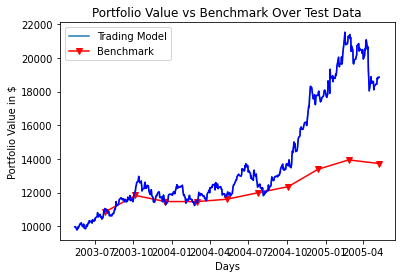

In [28]:
# Test Stock Prices and actions taken by agent Stock Plot
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline

pd_bm=pd.DataFrame.from_records(Benchmark_Port_Value)
pd_bm[0]=pd.to_datetime(pd_bm[0], format='%Y/%m/%d')

x1 = np.array(pd_data1_test['Date'])
y1 = portfolio_value

x2=pd_bm[0]
y2=pd_bm[1]



plt.title("Portfolio Value vs Benchmark Over Test Data")
plt.xlabel("Days")
plt.ylabel("Portfolio Value in $")

plt.plot(x1,y1)
plt.plot_date(x2, y2, c = 'red', marker='v', linestyle='-')


#plt.plot(x1, z, '-', color='black');
plt.plot(x1, y1, '-', color='blue');



#plt.scatter(x1,Benchmark_Port_Value,marker='o')

plt.legend(('Trading Model', 'Benchmark'))

plt.show()